In [1]:
# !pip install einops

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
# from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
# from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import h5py as h5
import hdf5plugin
import einops
import copy
from matplotlib.colors import LogNorm

In [2]:
class Transformer(nn.Module):
    def __init__(self, input_dim, embed_dim, hidden_size):
        super().__init__()

        self.embed = nn.Sequential(
                nn.Linear(input_dim, embed_dim),
                nn.ReLU(),
        )

        
        self.encoder_layer_1 = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True, dim_feedforward=embed_dim)
        self.encoder_layer_2 = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True, dim_feedforward=embed_dim)
        self.encoder_layer_3 = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True, dim_feedforward=embed_dim)
        # self.encoder_layer_4 = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=4, batch_first=True, dim_feedforward=embed_dim)
        
        
        self.classifier = nn.Sequential(
                nn.Linear(embed_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, 1),
                nn.Sigmoid(),
        )
    
    def forward(self, x, mask=None):
        with torch.backends.cuda.sdp_kernel(enable_flash=False, enable_math=True, enable_mem_efficient=False):
            x = self.embed(x)
            x = self.encoder_layer_1(x)
            x = self.encoder_layer_2(x)
            x = self.encoder_layer_3(x)
            # x = self.encoder_layer_4(x)
            x = torch.sum(x*mask.unsqueeze(-1), axis=1)
            return self.classifier(x)
        

In [3]:
class DeepSet(nn.Module):
    def __init__(self, input_dim, rho_size, phi_size,):
        super().__init__()

        self.rho = nn.Sequential(
                nn.Linear(input_dim, rho_size),
                nn.ReLU(),
                nn.Linear(rho_size, rho_size),
                nn.ReLU(),
                nn.Linear(rho_size, rho_size),
                nn.ReLU(),
                nn.Linear(rho_size, rho_size)
        )

        self.phi = nn.Sequential(
                nn.Linear(rho_size, phi_size),
                nn.ReLU(),
                nn.Linear(phi_size, phi_size),
                nn.ReLU(),
                nn.Linear(phi_size, phi_size),
                nn.ReLU(),
                nn.Linear(phi_size, 1),
                nn.Sigmoid(),
        )
    def forward(self, x, mask=None):
        x = self.rho(x)
        x = torch.sum(x*mask.unsqueeze(-1), axis=1)
        return self.phi(x)

In [4]:
class JetDataset(Dataset):
    def __init__(self, X, y, mask, X_cylindrical=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.mask = mask
        self.X_cylindrical = X_cylindrical
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.X_cylindrical != None:
            return self.X[idx], self.y[idx], self.mask[idx], self.X_cylindrical[idx]
        else:
            return self.X[idx], self.y[idx], self.mask[idx]

In [5]:
def to_cylindrical(four_vec, log=True):
    E = four_vec[:,:,0]
    px = four_vec[:,:,1]
    py = four_vec[:,:,2]
    pz = four_vec[:,:,3]
    pt = torch.sqrt(px*px + py*py)
    phi = torch.arctan2(py,px)
    eta = torch.arcsinh(pz/pt)

    if log:
        cylindrical_four_vec = torch.cat([
            torch.log(E.unsqueeze(-1)),
            torch.log(pt.unsqueeze(-1)), 
            eta.unsqueeze(-1),
            phi.unsqueeze(-1)
        ], axis=2)

        cylindrical_four_vec = torch.where(cylindrical_four_vec < -1e30, 0.0, cylindrical_four_vec)
    else:
        cylindrical_four_vec = torch.cat([E.unsqueeze(-1),pt.unsqueeze(-1), eta.unsqueeze(-1),phi.unsqueeze(-1)], axis=2)

    
    return torch.nan_to_num(cylindrical_four_vec)

def get_jet_relvars(four_vec, four_vec_cy):
    
    jet_four_vec = torch.sum(four_vec, dim=1)
    jet_four_vec_cy = to_cylindrical(jet_four_vec.unsqueeze(1))

    # log(E_const/E_jet)
    log_Er = four_vec_cy[:,:,0] - jet_four_vec_cy[:,:,0]

    # log(pt_const/pt_jet)
    log_ptr = four_vec_cy[:,:,1] - jet_four_vec_cy[:,:,1]

    # dEta
    dEta = jet_four_vec_cy[:,:,2] - four_vec_cy[:,:,2] 

    # dPhi
    dPhi = jet_four_vec_cy[:,:,3] - four_vec_cy[:,:,3] 

    # dR
    dR = torch.sqrt(dEta**2 + dPhi**2)

    jet_features = torch.cat([log_Er.unsqueeze(-1), log_ptr.unsqueeze(-1), dEta.unsqueeze(-1), dPhi.unsqueeze(-1), dR.unsqueeze(-1)], axis=2)

    zero_mask = (four_vec == 0.0).any(dim=-1, keepdim=True)
    zero_mask = zero_mask.expand_as(jet_features)
    jet_features[zero_mask] = 0.0
    
    return jet_features
    

def boost_3d(data, device="cpu", beta=None, beta_max=1.0):

    # sample beta from sphere
    b1 = torch.tensor(np.random.uniform(0, 1, size=len(data)), dtype=torch.float32)
    b2 = torch.tensor(np.random.uniform(0, 1, size=len(data)), dtype=torch.float32)
    theta = 2 * np.pi * b1
    phi = np.arccos(1 - 2 * b2)
    
    beta_x = np.sin(phi) * np.cos(theta)
    beta_y = np.sin(phi) * np.sin(theta)
    beta_z = np.cos(phi)
    
    beta = torch.cat([beta_x.unsqueeze(-1),beta_y.unsqueeze(-1), beta_z.unsqueeze(-1)], axis=1)
    # bf = torch.tensor(np.random.uniform(0, beta_max, size=(len(data),1)), dtype=torch.float32)
    # bf = bf**(1/2)
    beta = beta*beta_max
    
    beta_norm = torch.norm(beta, dim=1) 

    # make sure we arent violating speed of light
    assert torch.all(beta_norm < 1)

    gamma = 1 / torch.sqrt(1 - (beta_norm)**2)

    beta_squared = (beta_norm)**2

    # make boost matrix
    L = torch.zeros((len(data), 4, 4)).to(device)
    L[:,0, 0] = gamma
    L[:,1:, 0] = L[:,0, 1:] = -gamma.unsqueeze(-1) * beta
    L[:, 1:, 1:] = torch.eye(3) + (gamma[...,None, None] - 1) * torch.einsum('bi,bj->bij', (beta, beta))/ beta_squared[...,None, None]
    
    assert torch.all (torch.linalg.det(L)) == True

    boosted_four_vector = torch.einsum('bij,bkj->bik', L.type(torch.float32), data.type(torch.float32)).permute(0, 2, 1) 

    # Validate that energy values remain non-negative
    assert torch.all(boosted_four_vector[:, :, 0] >= 0), "Negative energy values detected!"
    
    return boosted_four_vector

def boost(data, pdgid=None, device="cpu", beta=None):
    # print(device)
    if beta is None:
        beta = torch.tensor(np.random.uniform(0, 0.99, size=len(data)), dtype=torch.float32)
    else:
        beta = beta*torch.ones(len(data))
        
    beta = beta.repeat(data.shape[1])
    gamma = (1-beta*beta)**(-0.5)

    beta = beta.to(device)
    gamma = gamma.to(device)

    E_b = gamma*(data[:,:,0].flatten()- beta* data[:,:,1].flatten() )
    px_b = gamma*(data[:,:,1].flatten() - beta* data[:,:,0].flatten())
    
    E_b = E_b.reshape(data.shape[0], data.shape[1])
    px_b = px_b.reshape(data.shape[0], data.shape[1])

    four_vec = torch.cat([ E_b.unsqueeze(-1), px_b.unsqueeze(-1), data[:,:,2:4]], axis = 2)
    four_vec = four_vec.to(device)

    # return  torch.cat([four_vec, data[:,:,4:]], axis = 2)
    return four_vec

In [6]:
# load data
data_file = "train.h5"
data =  h5.File(data_file, 'r')

In [7]:
X = data["table"]["table"]["values_block_0"]
Y = data["table"]["table"]["values_block_1"]
Y = Y[:,1]

In [8]:
X_QCD = X[np.where(Y==0)]
Y_QCD = Y[np.where(Y==0)]
X_top = X[np.where(Y==1)]
Y_top = Y[np.where(Y==1)]

In [9]:
X_QCD_const = X_QCD[:,:800].reshape(len(X_QCD), 200, 4)
X_top_const = X_top[:,:800].reshape(len(X_top), 200, 4)
X_top_truth = X_top[:,800:].reshape(len(X_top), 4)

In [10]:
mask_QCD = np.all(X_QCD_const != 0, axis=2)
mask_top = np.all(X_top_const != 0, axis=2)

In [11]:
nj = 500_000
X = np.concatenate([X_QCD_const, X_top_const])
Y = np.concatenate([Y_QCD, Y_top])
mask = np.concatenate([mask_QCD, mask_top])

In [12]:
def shuffle(a ,b ,c):
    idx = np.random.permutation(len(a))
    return a[idx], b[idx], c[idx]

In [13]:
X, Y, mask = shuffle(X, Y, mask)
train_X = X[:nj]
train_Y = Y[:nj]
train_mask = mask[:nj]

In [14]:
train_X_cylindrical = to_cylindrical(torch.tensor(train_X, dtype=torch.float32))

In [15]:
train_jet_vars = get_jet_relvars(torch.tensor(train_X, dtype=torch.float32), train_X_cylindrical)

In [16]:
train_X_cylindrical = torch.cat([train_X_cylindrical,train_jet_vars], axis=2)

In [17]:
data = JetDataset(X=train_X,
                  y=train_Y,
                  mask=train_mask,
                  X_cylindrical=train_X_cylindrical
                 )
loader = DataLoader(
    data,
    batch_size=512,
    shuffle=True
)

In [18]:
class SymmLoss_pT_eta_phi(nn.Module):

    def __init__(self,model, gens_list = ["Lx", "Ly", "Lz", "Kx", "Ky", "Kz"],device="cpu"):
        super(SymmLoss_pT_eta_phi, self).__init__()
        
        self.device = device
        self.model = model.to(device)
        
        # Initialize generators (in future add different reps for inputs?)
        GenList_names = []
        Lorentz_names = ["Lx", "Ly", "Lz", "Kx", "Ky", "Kz"]
        for gen in gens_list:
            if gen in Lorentz_names:
                GenList_names.append(gen)
            else:
                print(f"generator \n {gen} needs to be one of: {Lorentz_names}") #This is for now. Later will add a part that deals with calculating the transforamtion for a given generator. 
                
                # self.generators = einops.rearrange(gens_list, 'n w h -> n w h')
                # self.generators = self.generators.to(device)
        self.generators = GenList_names
        
        

    def forward(self, input, model_rep='scalar',norm = "none",nfeatures = "", mask=None, log_E=False, log_pT=False):
        
        input = input.clone().detach().requires_grad_(True)
        input = input.to(self.device)

        # input_p4 = input
        if nfeatures!="":
            dim = nfeatures
        else:
            dim = 4 #self.generators.shape[-1]
        #Assuming input is shape [B,d*N] d is the number of features, N is the number of particles
        # input_reshaped = einops.rearrange(input, '... (N d) -> ... N d',d = dim)
        
        E =  torch.exp(input[:,:,0]) if log_E else input[:,:,0]  #assuming input features are ordered as (E,pT,eta,phi)
        
        pT = torch.exp(input[:,:,1]) if log_pT else input[:,:,1]
        
        eta = input[:,:,2]
        
        phi = input[:,:,3]
        
        GenList = self.generators

        # Add back in masked particles
        E = torch.masked_fill(E, ~mask, 0)
        pT = torch.masked_fill(pT, ~mask, 0)

        
        #dvar/dp L p, 
        ngen = len(self.generators)
        dE = torch.zeros_like(E).to(self.device)
        dpT = torch.zeros_like(pT).to(self.device)
        deta = torch.zeros_like(eta).to(self.device)
        dphi = torch.zeros_like(phi).to(self.device)
        
        
        #Here for all the Lorentz generators. Later can add options for only some of them.
        dE   = {"Lx": torch.zeros_like(E),              "Ly": torch.zeros_like(E),                "Lz":  torch.zeros_like(E),  "Kx":pT*torch.cos(phi),                    "Ky":pT*torch.sin(phi),                    "Kz":pT*torch.sinh(eta)}
        dpT  = {"Lx": pT*torch.sin(phi)*torch.sinh(eta),"Ly": -pT*torch.cos(phi)*torch.sinh(eta), "Lz":  torch.zeros_like(pT), "Kx":E*torch.cos(phi),                     "Ky":E*torch.sin(phi),                     "Kz":torch.zeros_like(pT)}
        deta = {"Lx": -1*torch.sin(phi)*torch.cosh(eta),  "Ly": torch.cos(phi)*torch.cosh(eta),     "Lz":  torch.zeros_like(eta),"Kx":-E*torch.cos(phi)*torch.tanh(eta)/pT, "Ky":-E*torch.sin(phi)*torch.tanh(eta)/pT, "Kz":E/(pT*torch.cosh(eta))}
        dphi = {"Lx":  torch.cos(phi)*torch.sinh(eta),  "Ly": torch.sin(phi)*torch.sinh(eta),     "Lz":-1*torch.ones_like(phi),"Kx":-E*torch.sin(phi)/pT,                 "Ky":E*torch.cos(phi)/pT,                  "Kz":torch.zeros_like(phi)}

        
        varsE = torch.empty(ngen,E.shape[0],E.shape[1]).to(self.device)
        varspT = torch.empty(ngen,E.shape[0],E.shape[1]).to(self.device)
        varseta = torch.empty(ngen,E.shape[0],E.shape[1]).to(self.device)
        varsphi = torch.empty(ngen,E.shape[0],E.shape[1]).to(self.device)
            
        for i,gen in enumerate(GenList):
            varsE[i] = dE[GenList[i]] /E if log_E else dE[GenList[i]]
            varspT[i] = dpT[GenList[i]] /pT if log_pT else dpT[GenList[i]]
            varseta[i] = deta[GenList[i]]
            varsphi[i] = dphi[GenList[i]]
        
        varsSymm = torch.stack((varsE,varspT,varseta,varsphi), dim = -1) #[n,B,N,d]

        # Deal with Nans from expressions like 0/0
        varsSymm = torch.nan_to_num(varsSymm, posinf=0., neginf=0.)
        
        #print(varsSymm.shape)
            
        # Compute model output, shape [B]
        output = self.model(input, mask)

        # Compute gradients with respect to input, shape [B, d*N], B is the batch size, d is the input irrep dimension, N is the number of particles
        grads_input, = torch.autograd.grad(outputs=output, inputs=input, grad_outputs=torch.ones_like(output, device=self.device), create_graph=True)

        
        
        # Reshape grads to [B, N, d]
        grads_input = grads_input.unsqueeze(0)
       
        
        # Dot with input [n ,B]
        differential_trans = torch.einsum('n ... N, ... N -> n ...', varsSymm, grads_input[:,:,:,:4]) # Input has 9 dimensions, only care about first 4 (LogE, LogpT, eta, phi)
        
        scalar_loss = (differential_trans ** 2).mean()
        

        
        return scalar_loss

In [19]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=15, device='cpu', apply_symm=False,lambda_symm = 1.0):

    model.to(device)
    symmLoss = SymmLoss_pT_eta_phi(model, device=device)
    
    # save the losses
    loss_tracker = {
        "Loss": [],
        "BCE": [],
        "Symm_Loss": [],
        "beta": []
    }
    failed_jets = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        rbce = 0.0
        rsymm = 0.0

        for batch_idx, batch in enumerate(tqdm(dataloader, desc=f"Epoch: {epoch}")):
            optimizer.zero_grad()  # Zero the gradients
            
            X, y, mask, X_cy = batch
            X = X.to(device)
            y = y.to(device)
            X_cy = X_cy.to(device)
            mask = mask.to(device)                
            
            outputs = model(X_cy, mask)
            bce = criterion(outputs.squeeze(), y)
            symm = symmLoss(X_cy, mask=mask)

            # print(symm)

            # loss =  bce + mse
            if apply_symm:
                loss = bce + lambda_symm*symm
            else:
                loss = bce 

            if torch.isinf(symm):
                print("Found infinity")
            
            loss.backward()  # Backward pass
            # gradients too large? 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
            
            optimizer.step()  # Update parameters

            running_loss += loss.item()
            rbce += bce.item()
            rsymm += symm.item()
            # rbeta += beta.item()
            # break
        

        running_loss /=len(dataloader)
        rbce /= len(dataloader)
        rsymm /= len(dataloader)
        # rbeta /= len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss:.4f}, BCE: {rbce:.4f}, Symm: {rsymm}')
        loss_tracker["Loss"].append(running_loss)
        loss_tracker["BCE"].append(rbce)
        loss_tracker["Symm_Loss"].append(rsymm)
        # loss_tracker["beta"].append(rbeta)
        # break
        model_clone = copy.deepcopy(model)
            
    
    return loss_tracker,model_clone

In [20]:
def test_lambdas(lambda_vec, dataloader, criterion = torch.nn.BCELoss(), optimizer = "Adam",lr = 5e-4, num_epochs=15, device='cpu', apply_symm=False,set_seed = True,seed = int(torch.round(torch.rand(1)*10000))):
    
    if set_seed:
            np.random.seed(seed)
            torch.manual_seed(seed)
            
    train_loader_copy = copy.deepcopy(dataloader)
    model = DeepSet(input_dim=9, rho_size=256, phi_size=128)
    train_outputs = {}
    models = {}
    
    for lam_val in lambda_vec:
        train_loader_copy = copy.deepcopy(dataloader)
        if set_seed:
            np.random.seed(seed)
            torch.manual_seed(seed)
            
        model_train = copy.deepcopy(model)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total model parameters: {total_params}")
        optimiser = torch.optim.Adam(model_train.parameters(), lr=lr)

        
        train_output,model_trained = train_model(model = model_train, dataloader = train_loader_copy, criterion = criterion, optimizer = optimiser, device="cuda",apply_symm=apply_symm,lambda_symm = lam_val)
        
        models[lam_val] = copy.deepcopy(model_trained)
        train_outputs[lam_val] = copy.deepcopy(train_output)
    
    return train_outputs,models
        
        
        

In [43]:
lambda_vec = [0.0,100,10000.0]
train_outputs,models = test_lambdas(lambda_vec = lambda_vec, dataloader = loader, criterion = torch.nn.BCELoss(), optimizer = "Adam",lr = 5e-4, num_epochs=15, device='cuda', apply_symm=True,set_seed = True,seed = 1000)


Total model parameters: 265985


Epoch: 0: 100%|██████████| 977/977 [00:44<00:00, 21.73it/s]


Epoch [1/15] Loss: 0.3654, BCE: 0.3654, Symm: 0.0011231614066008412


Epoch: 1: 100%|██████████| 977/977 [00:44<00:00, 21.80it/s]


Epoch [2/15] Loss: 0.2710, BCE: 0.2710, Symm: 0.0005314870316545005


Epoch: 2: 100%|██████████| 977/977 [00:44<00:00, 21.77it/s]


Epoch [3/15] Loss: 0.2577, BCE: 0.2577, Symm: 0.0010515169938326195


Epoch: 3: 100%|██████████| 977/977 [00:44<00:00, 21.72it/s]


Epoch [4/15] Loss: 0.2499, BCE: 0.2499, Symm: 0.0017241857583655288


Epoch: 4: 100%|██████████| 977/977 [00:44<00:00, 21.76it/s]


Epoch [5/15] Loss: 0.2421, BCE: 0.2421, Symm: 0.0016808169779381804


Epoch: 5: 100%|██████████| 977/977 [00:44<00:00, 21.75it/s]


Epoch [6/15] Loss: 0.2370, BCE: 0.2370, Symm: 0.0007695947507470931


Epoch: 6: 100%|██████████| 977/977 [00:44<00:00, 21.76it/s]


Epoch [7/15] Loss: 0.2307, BCE: 0.2307, Symm: 0.00215254002366908


Epoch: 7: 100%|██████████| 977/977 [00:45<00:00, 21.46it/s]


Epoch [8/15] Loss: 0.2254, BCE: 0.2254, Symm: 0.0034455876754422386


Epoch: 8: 100%|██████████| 977/977 [00:45<00:00, 21.61it/s]


Epoch [9/15] Loss: 0.2225, BCE: 0.2225, Symm: 0.004350091882115931


Epoch: 9: 100%|██████████| 977/977 [00:45<00:00, 21.67it/s]


Epoch [10/15] Loss: 0.2212, BCE: 0.2212, Symm: 0.003840977995959802


Epoch: 10: 100%|██████████| 977/977 [00:44<00:00, 21.79it/s]


Epoch [11/15] Loss: 0.2193, BCE: 0.2193, Symm: 0.00658700855698712


Epoch: 11: 100%|██████████| 977/977 [00:44<00:00, 21.75it/s]


Epoch [12/15] Loss: 0.2183, BCE: 0.2183, Symm: 0.007622354882887251


Epoch: 12: 100%|██████████| 977/977 [00:44<00:00, 21.73it/s]


Epoch [13/15] Loss: 0.2177, BCE: 0.2177, Symm: 0.012816343500892304


Epoch: 13: 100%|██████████| 977/977 [00:45<00:00, 21.69it/s]


Epoch [14/15] Loss: 0.2167, BCE: 0.2167, Symm: 0.02357106608766543


Epoch: 14: 100%|██████████| 977/977 [00:44<00:00, 21.77it/s]


Epoch [15/15] Loss: 0.2158, BCE: 0.2158, Symm: 0.11669775489524689
Total model parameters: 265985


Epoch: 0: 100%|██████████| 977/977 [00:45<00:00, 21.36it/s]


Epoch [1/15] Loss: 1.4932, BCE: 0.4199, Symm: 0.010732168446646501


Epoch: 1: 100%|██████████| 977/977 [00:45<00:00, 21.51it/s]


Epoch [2/15] Loss: 0.3273, BCE: 0.2889, Symm: 0.00038328160557928904


Epoch: 2: 100%|██████████| 977/977 [00:45<00:00, 21.48it/s]


Epoch [3/15] Loss: 0.2781, BCE: 0.2684, Symm: 9.651615811960973e-05


Epoch: 3: 100%|██████████| 977/977 [00:45<00:00, 21.41it/s]


Epoch [4/15] Loss: 0.2684, BCE: 0.2601, Symm: 8.28837655736125e-05


Epoch: 4: 100%|██████████| 977/977 [00:45<00:00, 21.67it/s]


Epoch [5/15] Loss: 0.3352, BCE: 0.2539, Symm: 0.0008133059285498656


Epoch: 5: 100%|██████████| 977/977 [00:45<00:00, 21.63it/s]


Epoch [6/15] Loss: 0.3264, BCE: 0.2478, Symm: 0.0007862790196094918


Epoch: 6: 100%|██████████| 977/977 [00:45<00:00, 21.66it/s]


Epoch [7/15] Loss: 0.2704, BCE: 0.2380, Symm: 0.0003240234830971246


Epoch: 7: 100%|██████████| 977/977 [00:45<00:00, 21.40it/s]


Epoch [8/15] Loss: 0.2485, BCE: 0.2320, Symm: 0.00016510183504504417


Epoch: 8: 100%|██████████| 977/977 [00:45<00:00, 21.67it/s]


Epoch [9/15] Loss: 0.2423, BCE: 0.2280, Symm: 0.0001433074356923326


Epoch: 9: 100%|██████████| 977/977 [00:45<00:00, 21.64it/s]


Epoch [10/15] Loss: 0.2365, BCE: 0.2273, Symm: 9.272344244911908e-05


Epoch: 10: 100%|██████████| 977/977 [00:45<00:00, 21.60it/s]


Epoch [11/15] Loss: 0.2503, BCE: 0.2247, Symm: 0.0002565952557223446


Epoch: 11: 100%|██████████| 977/977 [00:45<00:00, 21.65it/s]


Epoch [12/15] Loss: 0.2621, BCE: 0.2243, Symm: 0.0003784836292418814


Epoch: 12: 100%|██████████| 977/977 [00:45<00:00, 21.69it/s]


Epoch [13/15] Loss: 0.2304, BCE: 0.2228, Symm: 7.61643665545537e-05


Epoch: 13: 100%|██████████| 977/977 [00:45<00:00, 21.67it/s]


Epoch [14/15] Loss: 0.2436, BCE: 0.2222, Symm: 0.00021423195061290288


Epoch: 14: 100%|██████████| 977/977 [00:45<00:00, 21.64it/s]


Epoch [15/15] Loss: 0.2365, BCE: 0.2207, Symm: 0.00015847971914093156
Total model parameters: 265985


Epoch: 0: 100%|██████████| 977/977 [00:45<00:00, 21.60it/s]


Epoch [1/15] Loss: 149.0428, BCE: 0.5888, Symm: 0.014845402217433776


Epoch: 1: 100%|██████████| 977/977 [00:45<00:00, 21.53it/s]


Epoch [2/15] Loss: 19.4402, BCE: 0.4439, Symm: 0.0018996280583107182


Epoch: 2: 100%|██████████| 977/977 [00:45<00:00, 21.57it/s]


Epoch [3/15] Loss: 8.2583, BCE: 0.4060, Symm: 0.0007852325098747501


Epoch: 3: 100%|██████████| 977/977 [00:45<00:00, 21.55it/s]


Epoch [4/15] Loss: 39.2340, BCE: 0.3688, Symm: 0.003886513907470889


Epoch: 4: 100%|██████████| 977/977 [00:45<00:00, 21.51it/s]


Epoch [5/15] Loss: 12.6447, BCE: 0.3004, Symm: 0.0012344273074202607


Epoch: 5: 100%|██████████| 977/977 [00:45<00:00, 21.56it/s]


Epoch [6/15] Loss: 0.4623, BCE: 0.2691, Symm: 1.9324111307691508e-05


Epoch: 6: 100%|██████████| 977/977 [00:45<00:00, 21.51it/s]


Epoch [7/15] Loss: 0.3479, BCE: 0.2637, Symm: 8.420391176270721e-06


Epoch: 7: 100%|██████████| 977/977 [00:45<00:00, 21.53it/s]


Epoch [8/15] Loss: 1.5461, BCE: 0.2591, Symm: 0.00012870306583434826


Epoch: 8: 100%|██████████| 977/977 [00:45<00:00, 21.40it/s]


Epoch [9/15] Loss: 0.7422, BCE: 0.2556, Symm: 4.8660515235215846e-05


Epoch: 9: 100%|██████████| 977/977 [00:45<00:00, 21.30it/s]


Epoch [10/15] Loss: 0.7374, BCE: 0.2510, Symm: 4.863327804292579e-05


Epoch: 10: 100%|██████████| 977/977 [00:45<00:00, 21.59it/s]


Epoch [11/15] Loss: 0.8618, BCE: 0.2439, Symm: 6.178399902363257e-05


Epoch: 11: 100%|██████████| 977/977 [00:45<00:00, 21.55it/s]


Epoch [12/15] Loss: 0.3549, BCE: 0.2410, Symm: 1.138871410548217e-05


Epoch: 12: 100%|██████████| 977/977 [00:45<00:00, 21.52it/s]


Epoch [13/15] Loss: 0.3872, BCE: 0.2387, Symm: 1.4849991199518338e-05


Epoch: 13: 100%|██████████| 977/977 [00:45<00:00, 21.59it/s]


Epoch [14/15] Loss: 0.2962, BCE: 0.2350, Symm: 6.122458536849421e-06


Epoch: 14: 100%|██████████| 977/977 [00:45<00:00, 21.55it/s]


Epoch [15/15] Loss: 0.3900, BCE: 0.2315, Symm: 1.5848679172108393e-05


(array([[0., 0., 0., ..., 5., 1., 1.],
        [0., 0., 0., ..., 5., 3., 0.],
        [0., 0., 0., ..., 3., 3., 0.],
        ...,
        [0., 0., 0., ..., 3., 3., 0.],
        [0., 0., 0., ..., 6., 3., 0.],
        [0., 0., 0., ..., 4., 1., 0.]]),
 array([-5.00032187, -3.85653257, -2.71274328, -1.56895411, -0.42516488,
         0.71862435,  1.86241364,  3.00620294,  4.14999199,  5.29378128,
         6.43757057]),
 <a list of 50000 BarContainer objects>)

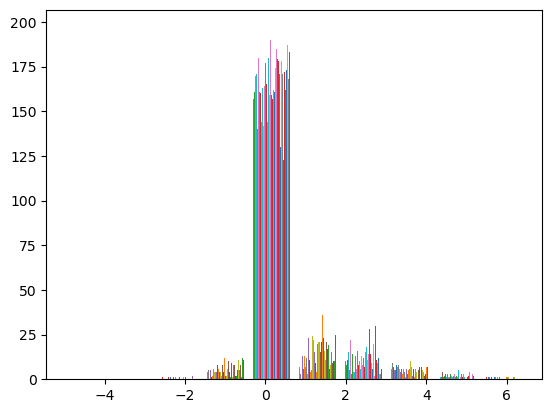

In [28]:
plt.hist(data.X_cylindrical[0::10,:,1])

In [21]:
# torch.autograd.set_detect_anomaly(True)

# model = Transformer(input_dim=9, embed_dim=256, hidden_size=128)

model = DeepSet(input_dim=9, rho_size=256, phi_size=128)


total_params = sum(p.numel() for p in model.parameters())
print(f"Total model parameters: {total_params}")
optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)

BCE = torch.nn.BCELoss()

Total model parameters: 265985


In [22]:
train_output = train_model(model, loader, BCE, optimiser, device="cuda")

Epoch: 0: 100%|██████████| 977/977 [00:31<00:00, 30.83it/s]


Epoch [1/15] Loss: 0.3704, BCE: 0.3704, Symm: 3.473077686798813


Epoch: 1: 100%|██████████| 977/977 [00:30<00:00, 31.96it/s]


Epoch [2/15] Loss: 0.2728, BCE: 0.2728, Symm: 4.2573648148894065


Epoch: 2: 100%|██████████| 977/977 [00:30<00:00, 31.78it/s]


Epoch [3/15] Loss: 0.2575, BCE: 0.2575, Symm: 0.953594375192021


Epoch: 3: 100%|██████████| 977/977 [00:30<00:00, 32.03it/s]


Epoch [4/15] Loss: 0.2480, BCE: 0.2480, Symm: 0.5762679337723107


Epoch: 4: 100%|██████████| 977/977 [00:30<00:00, 31.86it/s]


Epoch [5/15] Loss: 0.2414, BCE: 0.2414, Symm: 0.6074227991846591


Epoch: 5: 100%|██████████| 977/977 [00:30<00:00, 31.67it/s]


Epoch [6/15] Loss: 0.2371, BCE: 0.2371, Symm: 0.46178428523677156


Epoch: 6: 100%|██████████| 977/977 [00:30<00:00, 31.93it/s]


Epoch [7/15] Loss: 0.2307, BCE: 0.2307, Symm: 0.8984282912196498


Epoch: 7: 100%|██████████| 977/977 [00:30<00:00, 32.01it/s]


Epoch [8/15] Loss: 0.2274, BCE: 0.2274, Symm: 1.3760823964035498


Epoch: 8: 100%|██████████| 977/977 [00:30<00:00, 31.94it/s]


Epoch [9/15] Loss: 0.2242, BCE: 0.2242, Symm: 52.036609246976056


Epoch: 9: 100%|██████████| 977/977 [00:30<00:00, 31.95it/s]


Epoch [10/15] Loss: 0.2218, BCE: 0.2218, Symm: 2.2220575359241015


Epoch: 10: 100%|██████████| 977/977 [00:30<00:00, 32.03it/s]


Epoch [11/15] Loss: 0.2204, BCE: 0.2204, Symm: 10.980549849470659


Epoch: 11: 100%|██████████| 977/977 [00:30<00:00, 31.85it/s]


Epoch [12/15] Loss: 0.2204, BCE: 0.2204, Symm: 4.3765685944498625


Epoch: 12: 100%|██████████| 977/977 [00:30<00:00, 32.05it/s]


Epoch [13/15] Loss: 0.2194, BCE: 0.2194, Symm: 4.367250013513111


Epoch: 13: 100%|██████████| 977/977 [00:30<00:00, 32.09it/s]


Epoch [14/15] Loss: 0.2180, BCE: 0.2180, Symm: 11.15147048175457


Epoch: 14: 100%|██████████| 977/977 [00:30<00:00, 32.09it/s]

Epoch [15/15] Loss: 0.2174, BCE: 0.2174, Symm: 19.83696887879313


In [23]:
model_symm = DeepSet(input_dim=9, rho_size=256, phi_size=128)
optimiser = torch.optim.Adam(model_symm.parameters(), lr=5e-4)
train_output_symm = train_model(model_symm, loader, BCE, optimiser, device="cuda", apply_symm=True)

Epoch: 0: 100%|██████████| 977/977 [00:45<00:00, 21.68it/s]


Epoch [1/15] Loss: 1.6279, BCE: 0.4517, Symm: 1.1761861234659319


Epoch: 1: 100%|██████████| 977/977 [00:45<00:00, 21.61it/s]


Epoch [2/15] Loss: 0.8102, BCE: 0.3410, Symm: 0.46924678782552115


Epoch: 2: 100%|██████████| 977/977 [00:45<00:00, 21.58it/s]


Epoch [3/15] Loss: 2.6876, BCE: 0.3007, Symm: 2.3868746820712383


Epoch: 3: 100%|██████████| 977/977 [00:45<00:00, 21.53it/s]


Epoch [4/15] Loss: 0.3422, BCE: 0.2761, Symm: 0.06607624533978942


Epoch: 4: 100%|██████████| 977/977 [00:45<00:00, 21.63it/s]


Epoch [5/15] Loss: 9.9358, BCE: 0.2696, Symm: 9.666159081608086


Epoch: 5: 100%|██████████| 977/977 [00:45<00:00, 21.66it/s]


Epoch [6/15] Loss: 2.4647, BCE: 0.2621, Symm: 2.2025520793065057


Epoch: 6: 100%|██████████| 977/977 [00:45<00:00, 21.62it/s]


Epoch [7/15] Loss: 0.6087, BCE: 0.2583, Symm: 0.35043383905370484


Epoch: 7: 100%|██████████| 977/977 [00:45<00:00, 21.63it/s]


Epoch [8/15] Loss: 0.2770, BCE: 0.2488, Symm: 0.02822775402887531


Epoch: 8: 100%|██████████| 977/977 [00:45<00:00, 21.62it/s]


Epoch [9/15] Loss: 0.3036, BCE: 0.2448, Symm: 0.0588367823641242


Epoch: 9: 100%|██████████| 977/977 [00:45<00:00, 21.64it/s]


Epoch [10/15] Loss: 0.2622, BCE: 0.2397, Symm: 0.022423673865834333


Epoch: 10: 100%|██████████| 977/977 [00:45<00:00, 21.48it/s]


Epoch [11/15] Loss: 0.2619, BCE: 0.2344, Symm: 0.027476536824025725


Epoch: 11: 100%|██████████| 977/977 [00:45<00:00, 21.67it/s]


Epoch [12/15] Loss: 0.2984, BCE: 0.2324, Symm: 0.06604085621858223


Epoch: 12: 100%|██████████| 977/977 [00:45<00:00, 21.64it/s]


Epoch [13/15] Loss: 0.2714, BCE: 0.2306, Symm: 0.04085874731188684


Epoch: 13: 100%|██████████| 977/977 [00:45<00:00, 21.60it/s]


Epoch [14/15] Loss: 0.2671, BCE: 0.2272, Symm: 0.03987269515186899


Epoch: 14: 100%|██████████| 977/977 [00:45<00:00, 21.66it/s]

Epoch [15/15] Loss: 0.2623, BCE: 0.2265, Symm: 0.035812182720138586


In [24]:
# bad_jet = train_output[1][0]

In [25]:
# for i in range(9):
#     plt.figure()'
#     var = train_X_cylindrical[:1_000,:,i].flatten()[train_mask[:1_000].flatten()]
#     bad_var = bad_jet[:,:,i].flatten()
#     # plt.hist(var, bins=50)
#     plt.hist(bad_var.cpu(), bins=50)

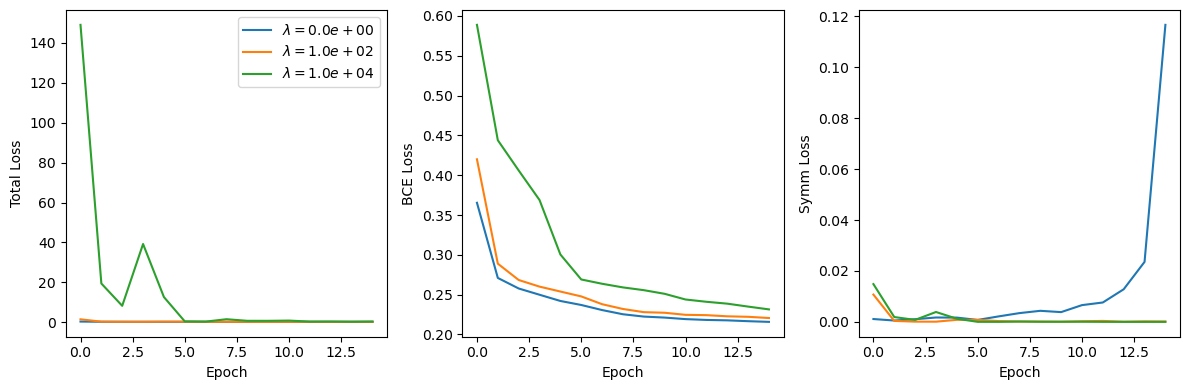

In [44]:

#losses_symm = train_outputs_symm
fig, ax = plt.subplots(1,3, figsize=(12,4))
for lam_val in train_outputs.keys():
    losses = train_outputs[lam_val]
    # Total Loss
    lam = f"{lam_val:.1e}"
    ax[0].plot(losses["Loss"], label=rf"$\lambda = {lam}$")
    #ax[0].plot(losses_symm["Loss"], label="Symm Loss Applied")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Total Loss")
    ax[0].legend()

    # BCE Component
    ax[1].plot(losses["BCE"])
    #ax[1].plot(losses_symm["BCE"])
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("BCE Loss")

    # MSE Component
    ax[2].plot(losses["Symm_Loss"])
    #ax[2].plot(losses_symm["Symm_Loss"])
    ax[2].set_xlabel("Epoch")
    ax[2].set_ylabel("Symm Loss")

fig.tight_layout()
plt.savefig("top_tagging_loss_100k_symmLoss_applied.png", dpi=150)

In [27]:
# test_data = "/share/rcifdata/tmadula/External/data/quark_gluon_aug/QG_jets_aug_2.npz"
# test_data = np.load(test_data)

In [58]:
# test_X = test_data["X"]
# test_y = test_data["y"]
# test_mask = np.where(test_X[:,:,0]==0, False, True)
# test_X = test_X[:,:,4:8]
# test_pdgid = test_data["X"][:,:,3]
# test_X_scaled = apply_scaling(test_X, train_mean, train_std, pdgid=test_pdgid)
# os = test_pdgid.shape
# test_pdig = ohe.transform(test_pdgid.reshape(-1,1)).toarray()
# test_pdig = test_pdig.reshape(os[0], os[1], 14)

test_X = X[nj:2*nj]
test_Y = Y[nj:2*nj]
test_mask = mask[nj:2*nj]
test_X_cy = to_cylindrical(torch.tensor(test_X, dtype=torch.float32))
test_jet_vars = get_jet_relvars(torch.tensor(test_X, dtype=torch.float32), test_X_cy)
test_X_cy = torch.cat([test_X_cy,test_jet_vars], axis=2)

test_data = JetDataset(test_X,test_Y, test_mask, test_X_cy)
test_loader = DataLoader(
    test_data,
    batch_size=128,
    shuffle=True
)

In [46]:
beta_max = np.linspace(0.64, 0.74, 1)

In [47]:
beta_max

array([0.64])

In [51]:
def evaluate_model(model, dataloader, device='cpu', max_betas = [1.0]):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    pred = []
    true = []
    boost_ = {mb: [] for mb in beta_max} 
    with torch.no_grad():  # Disable gradient calculation
        for idx, batch in enumerate(dataloader):
            X, y, mask, X_cy = batch
            
            X = X.to(device)
            y = y.to(device)
            mask = mask.to(device)
            X_cy = X_cy.to(device)
            outputs = model(X_cy, mask)  # Forward pass
            pred.append(outputs)
            true.append(y)

            for mb in beta_max:
                if idx ==0:
                    print(f"Max beta: {np.sqrt(mb)}")
                X_boost = boost_3d(X, device=device, beta_max=mb)
                X_boost_cy = to_cylindrical(X_boost)
                jet_vars = get_jet_relvars(X_boost, X_boost_cy)
                X_boost_cy = torch.cat([X_boost_cy,jet_vars], axis=2)                         
        
                outputs_boost = model(X_boost_cy, mask)
                boost_[mb].append(outputs_boost)
    
    model.to("cpu")
    for mb in beta_max:
        boost_[mb] = torch.cat(boost_[mb])

    return torch.cat(pred), boost_, torch.cat(true)

Max beta: 0.8
Max beta: 0.8


In [49]:
from sklearn.metrics import roc_curve, auc, accuracy_score

In [57]:
def get_metrics(pred, true, boost, beta_max):
    bm = {"auc": [], "acc": [], "boost_auc": [], "boost_acc":[] }
    
    fpr, tpr, threshold = roc_curve(true.cpu(), pred.cpu())
    roc_auc = bm["auc"].append(auc(fpr, tpr))
    acc = accuracy_score(true.cpu(), (pred >= 0.5).int().cpu())
    bm["acc"].append(acc)
    
    for mb in beta_max:
        fprb, tprb, _ = roc_curve(true.cpu(), boost[mb].cpu())
        roc_aucb = auc(fprb, tprb)
        accb = accuracy_score(true.cpu(), (boost[mb] >= 0.5).int().cpu())
        bm["boost_auc"].append(roc_aucb)
        bm["boost_acc"].append(accb)
    return bm

In [59]:
pred = {}
boost = {}
true = {}
for lam_val in models.keys():
    pred[lam_val], boost[lam_val], true[lam_val] = evaluate_model(model = models[lam_val], dataloader = test_loader, device="cuda")
#preds, boosts, trues = evaluate_model(model_symm, test_loader, device="cuda")
    bm = get_metrics(pred[lam_val], true[lam_val], boost[lam_val], beta_max)
    print(rf"$\lambda$ = {lam_val}: AUC =  {bm['auc'][0]},boosted AUC =  {bm['boost_auc'][0]}" )
#sm = get_metrics(preds, trues, boosts, beta_max)

Max beta: 0.8
$\lambda$ = 0.0: AUC =  0.9676186239806872,boosted AUC =  0.8511536742708647
Max beta: 0.8
$\lambda$ = 100: AUC =  0.9652151529390623,boosted AUC =  0.8248405178227336
Max beta: 0.8
$\lambda$ = 10000.0: AUC =  0.9640980977121965,boosted AUC =  0.8093850799307453


In [36]:
print(bm["auc"][0],bm["boost_auc"][0] )
print(sm["auc"][0], sm["boost_auc"][0])

0.9681938442168747 0.8579840966935961
0.966320260287782 0.8493448817095486


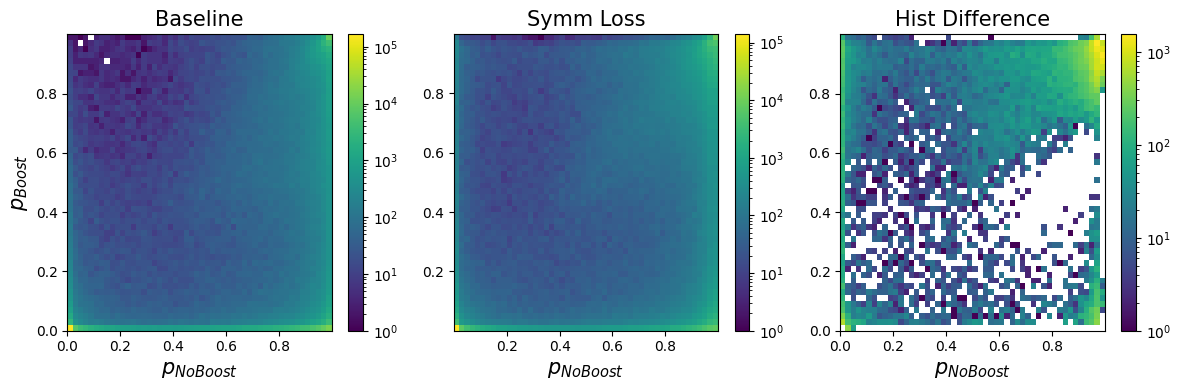

In [37]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

for lam_val in pred.keys():
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    h1, xedges, yedges, img1= ax[0].hist2d(pred[0.0].cpu().numpy().flatten(), boost[0.0][0.64].cpu().numpy().flatten(), bins=50, norm=LogNorm())
    h2, _, _, img2  = ax[1].hist2d(pred[lam_val].cpu().numpy().flatten(), boost[lam_val][0.64].cpu().numpy().flatten(), bins=50, norm=LogNorm());

    hdiff = h2 - h1

    img3= ax[2].imshow(hdiff.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],  aspect='auto', norm=LogNorm())
    ax[0].set_ylabel("$p_{Boost}$", fontsize=15)
    ax[0].set_xlabel("$p_{No Boost}$", fontsize=15)
    ax[1].set_xlabel("$p_{No Boost}$", fontsize=15)
    ax[2].set_xlabel("$p_{No Boost}$", fontsize=15)

    ax[0].set_title("Baseline", fontsize=15)
    ax[1].set_title("Symm Loss", fontsize=15)
    ax[2].set_title("Hist Difference", fontsize=15)

    fig.colorbar(img1, ax=ax[0], orientation='vertical')
    fig.colorbar(img2, ax=ax[1], orientation='vertical')
    fig.colorbar(img3, ax=ax[2], orientation='vertical')
    plt.tight_layout()
    plt.show()


# plt.savefig("100k_with_symm_scatter_0.4.png", dpi=150)

In [21]:
from symm_loss_defs import *

Using cuda device


In [24]:
filename = "top_DeepSetdata_seed_0_train_seed_0"
with open(f"./storage/{filename}.pkl","rb") as f:
        a = pickle.load(f)


Using cuda device


In [25]:
a.train_outputs

{0.0: {'Loss': [0.3605217601772219,
   0.2769111197979448,
   0.2611236354467691,
   0.2501325265045908,
   0.2434165649489712,
   0.236995651204608,
   0.23098414736736028,
   0.22644971329394725,
   0.224259519223181,
   0.22276544561771677,
   0.22153042427654032,
   0.21928009206282323,
   0.21915738615555308,
   0.217703560052655,
   0.2169008312657277],
  'BCE': [0.3605217601772219,
   0.2769111197979448,
   0.2611236354467691,
   0.2501325265045908,
   0.2434165649489712,
   0.236995651204608,
   0.23098414736736028,
   0.22644971329394725,
   0.224259519223181,
   0.22276544561771677,
   0.22153042427654032,
   0.21928009206282323,
   0.21915738615555308,
   0.217703560052655,
   0.2169008312657277],
  'Symm_Loss': [0.0010824581212969132,
   0.0004232928939468724,
   0.0005901066267394872,
   0.0005346121591452209,
   0.0013041504920722903,
   0.0014252546329608668,
   0.001827020861507282,
   0.003272665981210467,
   0.003203079755223302,
   0.007008585970286502,
   0.01943805